In [ ]:
!pip install -U albumentations 
# Install ultralytics
!pip -q install  ultralytics

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import cv2
import os
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial
# --- Set Reproducibility ---
import torch
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
# Directories and File Paths
csv_path = "/kaggle/input/ghana-crop-disease/Train.csv"  # Original train CSV file
image_dir = "/kaggle/input/ghana-crop-disease/images/"  # Directory containing original images
output_dir = "Level_Up/"  # Directory to save augmented images
os.makedirs(output_dir, exist_ok=True)

# Load CSV and Filter Minority Classes
minority_classes = ["Pepper_Late_Blight", "Tomato_Bacterial_Spot", "Pepper_Fusarium",
                    "Pepper_Cercospora", "Tomato_Leaf_Curl" ,"Tomato_Fusarium" ,"Pepper_Healthy" , "Pepper_Leaf_Blight"]

  
df = pd.read_csv(csv_path)
minority_df = df[df['class'].isin(minority_classes)]

# Albumentations Transformation Pipeline
train_transforms = A.Compose([
    # Color-Based Augmentation
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
    ], p=0.9),

    # Weather Simulation
    A.OneOf([
        A.Equalize(p=0.7),
        A.RandomRain(p=0.6)

    ], p=0.8),

    # Geometric Deformations
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.8),

    A.HorizontalFlip(p = 0.6),

    # Texture Simulation
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=0.7),
        A.ImageCompression(quality_lower=50, quality_upper=100, p=0.9),
    ], p=0.7),

    # Occlusion

    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Function to Process One Image
def process_image(image_id, image_dir, output_dir, df, train_transforms):
    image_data = df[df['Image_ID'] == image_id]

    # Load the image
    image_path = os.path.join(image_dir, image_id)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get bounding boxes and labels
    bboxes = image_data[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
    labels = image_data['class'].tolist()

    # List to store augmentation results
    augmented_data = []

    # Apply 2 augmentations
    for i in range(2):
        augmented = train_transforms(image=image, bboxes=bboxes, labels=labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['labels']

        # Save the augmented image
        aug_image_id = f"{os.path.splitext(image_id)[0]}_aug{i+1}.jpg"
        aug_image_path = os.path.join(output_dir, aug_image_id)
        cv2.imwrite(aug_image_path, cv2.cvtColor(aug_image.permute(1, 2, 0).cpu().numpy(), cv2.COLOR_RGB2BGR))

        # Append augmented data
        for bbox, label in zip(aug_bboxes, aug_labels):
            augmented_data.append({
                'Image_ID': aug_image_id,
                'confidence': 1,  # Assuming confidence is always 1 for augmented images
                'class': label,
                'xmin': bbox[0],
                'ymin': bbox[1],
                'xmax': bbox[2],
                'ymax': bbox[3]
            })

    return augmented_data

# Function to Parallelize Processing
def parallel_process_images(image_ids, image_dir, output_dir, df, train_transforms):
    results = []
    with Pool(processes=cpu_count()) as pool:
        func = partial(process_image, image_dir=image_dir, output_dir=output_dir, df=df, train_transforms=train_transforms)
        for result in tqdm(pool.imap(func, image_ids), total=len(image_ids), desc="Augmenting Images"):
            results.extend(result)
    return results

# Execute Augmentation with Multiprocessing
if __name__ == "__main__":
    augmented_data = parallel_process_images(
        minority_df['Image_ID'].unique(),
        image_dir,
        output_dir,
        minority_df,
        train_transforms
    )

    # Combine Original and Augmented Data
    augmented_df = pd.DataFrame(augmented_data)
    final_df = pd.concat([df, augmented_df], ignore_index=True)

    # Save the Updated CSV
    final_df.to_csv("augmented_train.csv", index=False)
    print("Augmented CSV saved as 'augmented_train.csv'")


Augmenting Images: 100%|██████████| 1109/1109 [08:01<00:00,  2.30it/s]


Augmented CSV saved as 'augmented_train.csv'


In [3]:
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial

# --- Paths ---
csv_path = "/kaggle/working/augmented_train.csv"  # Original train CSV file
image_dir = "/kaggle/input/ghana-crop-disease/images/"  # Directory containing original images
output_dir = "Level_Up/"  # Directory to save augmented images


# --- Load CSV ---
print("Loading dataset...")
df = pd.read_csv(csv_path)

# --- Filter Minority Classes ---
minority_classes = ['Corn_Northern_Leaf_Blight', 'Tomato_Mosaic', 'Pepper_Early_Blight']
minority_df = df[df['class'].isin(minority_classes)]

# --- Albumentations Transformations ---
bbox_params = A.BboxParams(format='pascal_voc', label_fields=['labels'])
transforms_list = [
    A.Equalize(always_apply=True),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=1.0),
    A.HorizontalFlip(always_apply=True),
    A.GaussianBlur(blur_limit=(3, 7), p=0.7),
    A.VerticalFlip(always_apply=True),
    A.Perspective(scale=(0.05, 0.1), keep_size=True, p=1.0),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1.0),
    A.ImageCompression(quality_lower=20, quality_upper=40, p=1.0),
    A.GridElasticDeform(num_grid_xy=(4, 4), magnitude=10, p=1.0),
    A.RandomSunFlare(p=1.0),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0),
    A.RandomRain(p=1.0)
]

# --- Function to Apply Augmentations ---
def validate_bboxes(bboxes):
    """Ensure bounding boxes are valid (i.e., non-zero area and within image bounds)."""
    valid_bboxes = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        if xmin < xmax and ymin < ymax:  # Check that width and height are positive
            valid_bboxes.append(bbox)
    return valid_bboxes

def process_image(image_id, image_dir, output_dir, df, transforms_list):
    image_data = df[df['Image_ID'] == image_id]

    # Load the image
    image_path = os.path.join(image_dir, image_id)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image {image_id}")
        return []
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get bounding boxes and labels
    bboxes = image_data[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
    labels = image_data['class'].tolist()

    # Validate bounding boxes (filter out invalid ones)
    bboxes = validate_bboxes(bboxes)
    if not bboxes:
        print(f"No valid bounding boxes for image {image_id}. Skipping.")
        return []

    augmented_data = []  # List to store augmentation results

    # Apply each transformation individually
    for idx, transform in enumerate(transforms_list):
        # Determine if bbox_params are needed
        use_bbox_params = isinstance(transform, (A.ShiftScaleRotate, A.HorizontalFlip, A.Perspective , A.GridElasticDeform ,A.VerticalFlip))

        # Compose transformation
        try:
            if use_bbox_params:
                aug_compose = A.Compose([transform], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
                augmented = aug_compose(image=image, bboxes=bboxes, labels=labels)
            else:
                aug_compose = A.Compose([transform])
                augmented = aug_compose(image=image)
                augmented['bboxes'] = bboxes  # Preserve original bboxes
                augmented['labels'] = labels  # Preserve original labels

            aug_img = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_labels = augmented['labels']

            # Generate new image ID
            aug_image_id = f"{os.path.splitext(image_id)[0]}_aug{idx + 1}.jpg"
            aug_image_path = os.path.join(output_dir, aug_image_id)

            # Save augmented image
            cv2.imwrite(aug_image_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

            # Append augmented data
            for bbox, label in zip(aug_bboxes, aug_labels):
                augmented_data.append({
                    'Image_ID': aug_image_id,
                    'confidence': 1,
                    'class': label,
                    'xmin': bbox[0],
                    'ymin': bbox[1],
                    'xmax': bbox[2],
                    'ymax': bbox[3]
                })
        except Exception as e:
            print(f"Augmentation error for image {image_id}, transform {idx}: {e}")

    return augmented_data

# --- Multiprocessing Wrapper ---
def parallel_process_images(image_ids, image_dir, output_dir, df, transforms_list):
    results = []
    with Pool(processes=cpu_count()) as pool:
        func = partial(process_image, image_dir=image_dir, output_dir=output_dir, df=df, transforms_list=transforms_list)
        for result in tqdm(pool.imap(func, image_ids), total=len(image_ids), desc="Augmenting Images"):
            results.extend(result)
    return results

# --- Execute Augmentation ---
if __name__ == "__main__":
    print("Applying sequential transformations to minority classes...")
    augmented_data = parallel_process_images(
        minority_df['Image_ID'].unique(),
        image_dir,
        output_dir,
        minority_df,
        transforms_list
    )

    # Combine Original and Augmented Data
    augmented_df = pd.DataFrame(augmented_data)
    final_df = pd.concat([df, augmented_df], ignore_index=True)

    # Save the Updated CSV
    final_df.to_csv("real_train.csv", index=False)
    print("Augmented CSV saved as 'augmented_train.csv'")


Loading dataset...
Applying sequential transformations to minority classes...


Augmenting Images:   0%|          | 0/98 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)
Augmenting Images:   8%|▊         | 8/98 [00:50<07:06,  4.74s/it]/opt/conda/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)
Augmenting Images:  10%|█         | 10/98 [01:02<07:33,  5.15s/it]/opt/conda/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)
Augmenting Images:  14%|█▍        | 14/98 [01:11<04:35,  3.28s/it]/opt/conda/lib/python3.10/site-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered i

Augmented CSV saved as 'augmented_train.csv'


In [4]:
import os
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from shutil import move, copy2
import cv2
import matplotlib.pyplot as plt

# --- Dataset Paths ---
DATA_DIR = Path('/kaggle/input/ghana-crop-disease')
AUGMENTED_IMAGES_DIR = Path('/kaggle/working/Level_Up')  # Augmented images directory
DATASET_DIR = Path('/kaggle/working/dataset')
IMAGES_DIR = DATA_DIR / 'images'
TRAIN_IMAGES_DIR = DATASET_DIR / 'images' / 'train'
VAL_IMAGES_DIR = DATASET_DIR / 'images' / 'val'
TRAIN_LABELS_DIR = DATASET_DIR / 'labels' / 'train'
VAL_LABELS_DIR = DATASET_DIR / 'labels' / 'val'

# Ensure directories exist
for dir_path in [TRAIN_IMAGES_DIR, VAL_IMAGES_DIR, TRAIN_LABELS_DIR, VAL_LABELS_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

# --- Load CSV Files ---
train = pd.read_csv("/kaggle/working/real_train.csv")

# Update image paths
train['image_path'] = train['Image_ID'].apply(
    lambda x: IMAGES_DIR / x if 'aug' not in x else AUGMENTED_IMAGES_DIR / x
)

# Map classes to numeric IDs
label_encoder = LabelEncoder()
train['class_id'] = label_encoder.fit_transform(train['class'])

# Split dataset into training and validation
unique_images = train.drop_duplicates(subset='Image_ID', ignore_index=True)
train_imgs, val_imgs = train_test_split(
    unique_images['Image_ID'],
    test_size=0.15,
    stratify=unique_images['class_id'],
    random_state=42
)
X_train = train[train.Image_ID.isin(train_imgs)].reset_index(drop=True)
X_val = train[train.Image_ID.isin(val_imgs)].reset_index(drop=True)

# --- Move Images Efficiently ---
def move_images(dataframe, target_dir, augmented_dir):
    """
    Move original and augmented images into the target directory efficiently.
    """
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc=f"Processing {target_dir}"):
        img_path = row['image_path']
        target_path = target_dir / Path(img_path).name
        target_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            if "aug" in str(img_path):  # Augmented images
                source_path = augmented_dir / Path(img_path).name
                if source_path.exists() and not target_path.exists():
                    move(source_path, target_path)
            else:  # Original images
                source_path = img_path
                if source_path.exists() and not target_path.exists():
                    copy2(source_path, target_path)
        except Exception as e:
            print(f"Error handling {img_path}: {e}")

# Move and organize images
print("Organizing training images...")
move_images(X_train, TRAIN_IMAGES_DIR, AUGMENTED_IMAGES_DIR)
print("Organizing validation images...")
move_images(X_val, VAL_IMAGES_DIR, AUGMENTED_IMAGES_DIR)

# Update paths in DataFrame after moving images
def update_image_paths(dataframe, target_dir):
    dataframe['image_path'] = dataframe['Image_ID'].apply(
        lambda x: Path(target_dir) / Path(x).name
    )

update_image_paths(X_train, TRAIN_IMAGES_DIR)
update_image_paths(X_val, VAL_IMAGES_DIR)


def verify_paths(dataframe):
    """
    Verify that all paths in the image_path column exist.
    """
    missing_files = dataframe[~dataframe['image_path'].apply(lambda x: Path(x).exists())]
    if not missing_files.empty:
        print(f"Missing files detected:\n{missing_files['image_path']}")
    else:
        print("All paths are valid.")



Organizing training images...


Processing /kaggle/working/dataset/images/train: 100%|██████████| 50077/50077 [01:36<00:00, 516.62it/s] 


Organizing validation images...


Processing /kaggle/working/dataset/images/val: 100%|██████████| 5444/5444 [00:11<00:00, 467.42it/s] 


In [5]:
# Verify for both training and validation sets
print("Verifying training image paths...")
verify_paths(X_train)
print("Verifying validation image paths...")
verify_paths(X_val)


Verifying training image paths...
All paths are valid.
Verifying validation image paths...
All paths are valid.


Saving training annotations...


Saving YOLO Annotations: 100%|██████████| 7414/7414 [03:48<00:00, 32.40it/s]

Saving validation annotations...



Saving YOLO Annotations: 100%|██████████| 824/824 [00:25<00:00, 32.71it/s]


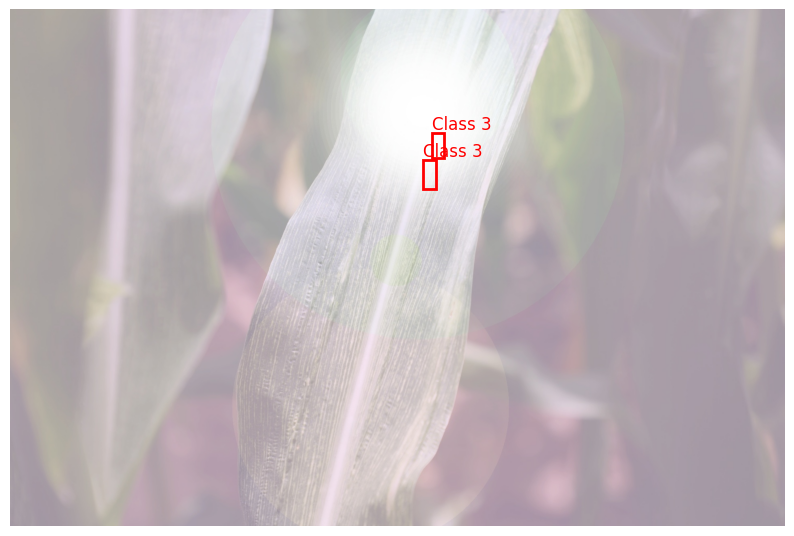

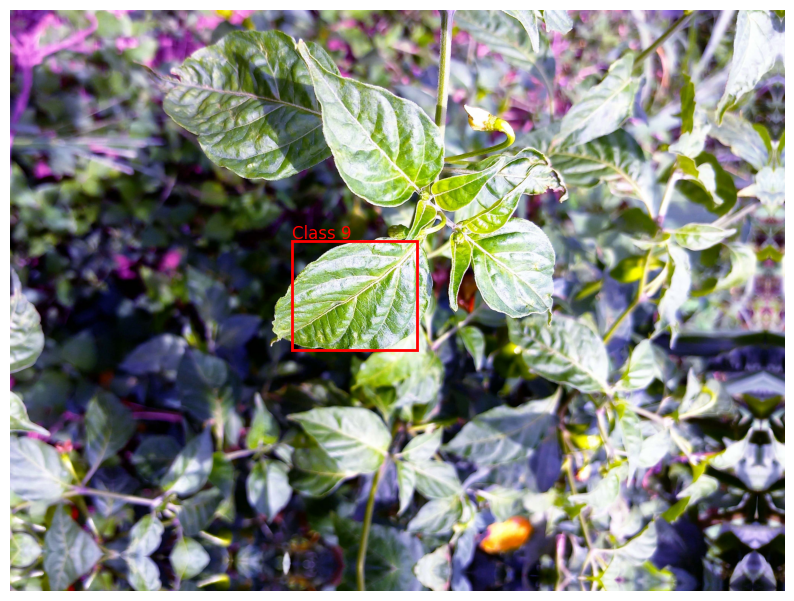

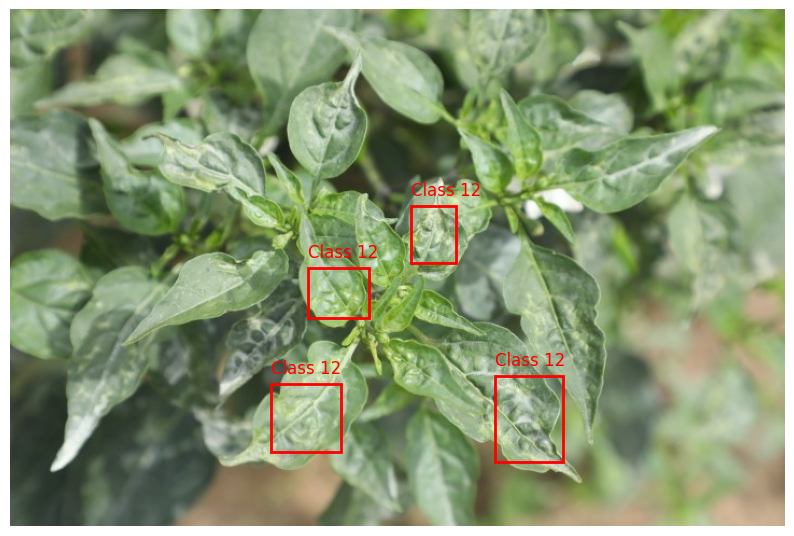

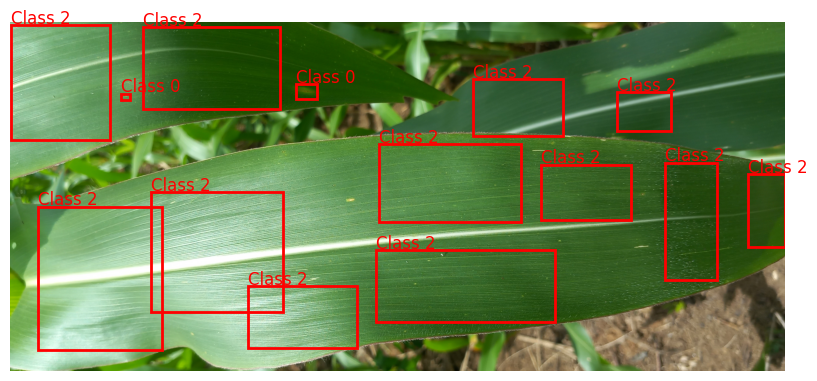

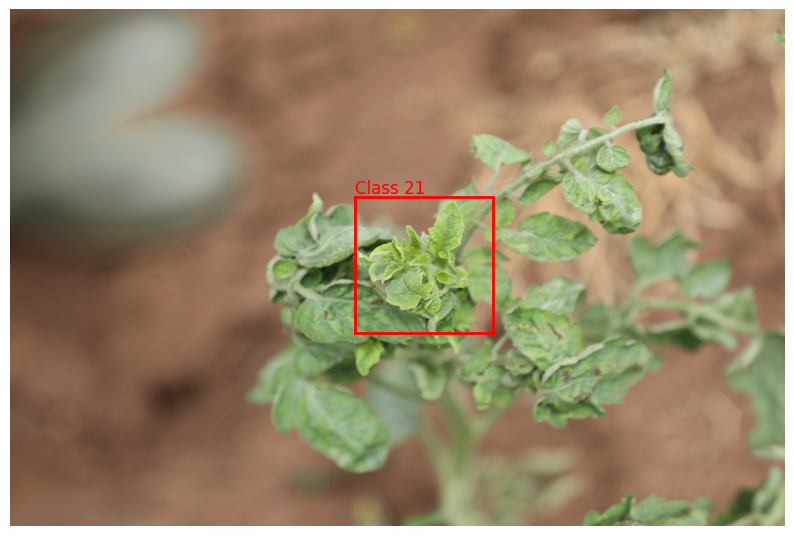

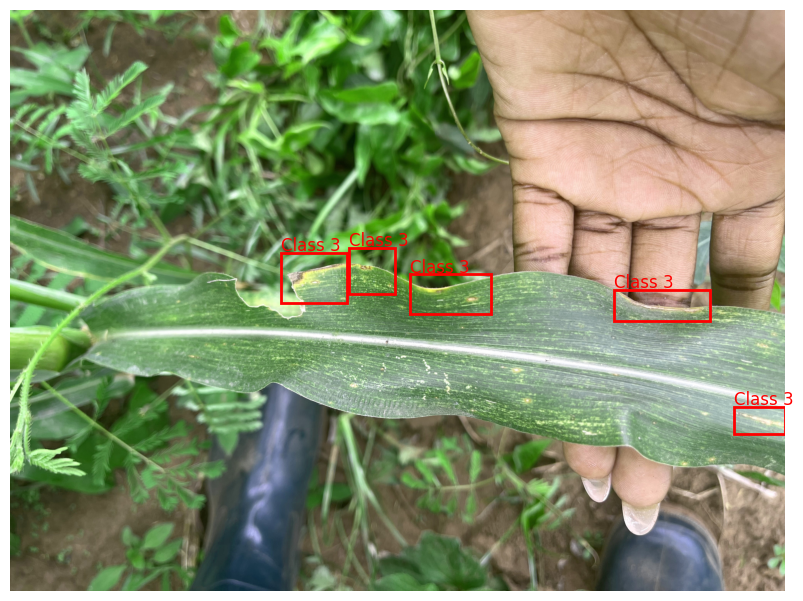

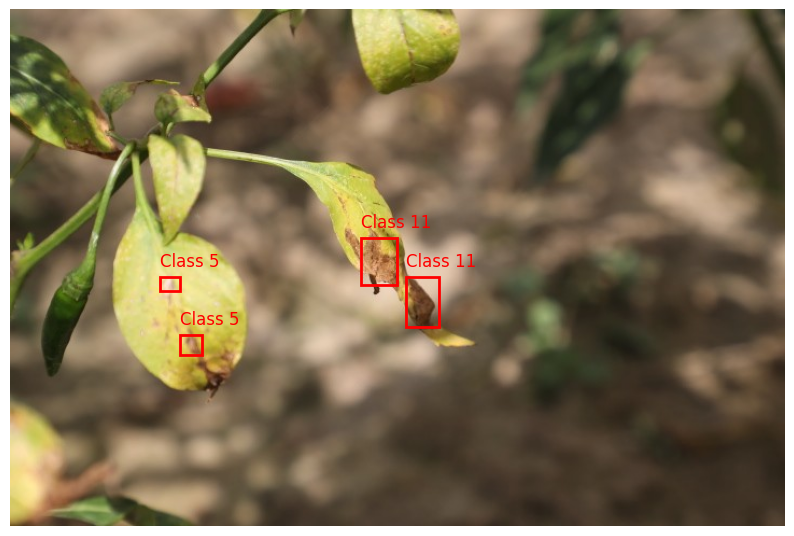

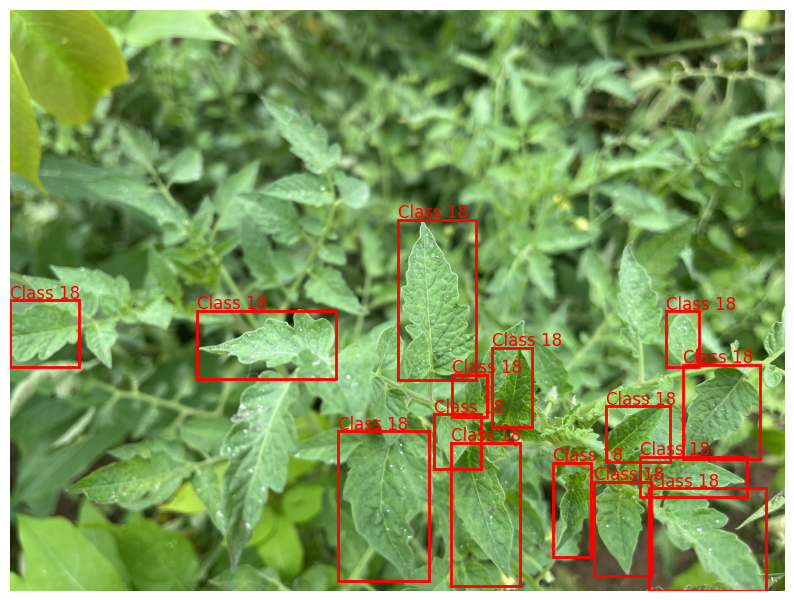

In [6]:
# --- Convert Bounding Boxes to YOLO Format ---
def convert_to_yolo(bbox, width, height):
    xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
    class_id = bbox['class_id']
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height
    return f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"

# --- Save YOLO Annotations ---
def save_yolo_annotation_task(task):
    img_path, group, output_dir = task
    try:
        if not img_path.exists():
            print(f"Image not found: {img_path}")
            return

        img = cv2.imread(str(img_path))
        if img is None:
            raise ValueError(f"Could not load image at {img_path}")

        height, width, _ = img.shape

        label_file = Path(output_dir) / f"{img_path.stem}.txt"
        label_file.parent.mkdir(parents=True, exist_ok=True)
        with open(label_file, 'w') as f:
            for _, row in group.iterrows():
                annotation = convert_to_yolo(row, width, height)
                f.write(f"{annotation}\n")
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

def save_yolo_annotations(dataframe, output_dir):
    grouped = dataframe.groupby("image_path")
    tasks = [(Path(img_path), group, output_dir) for img_path, group in grouped]
    with Pool(cpu_count()) as pool:
        list(tqdm(pool.imap(save_yolo_annotation_task, tasks), total=len(tasks), desc="Saving YOLO Annotations"))


# Save YOLO annotations
print("Saving training annotations...")
save_yolo_annotations(X_train, TRAIN_LABELS_DIR)
print("Saving validation annotations...")
save_yolo_annotations(X_val, VAL_LABELS_DIR)


# --- Visualization ---
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        return [list(map(float, line.strip().split())) for line in f.readlines()]

def plot_image_with_boxes(image_path, boxes):
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    plt.figure(figsize=(10, 10))
    plt.imshow(img)

    for box in boxes:
        class_id, x_center, y_center, width, height = box
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f"Class {int(class_id)}", color='red', fontsize=12)

    plt.axis("off")
    plt.show()

# Visualize a few samples
for image_name in os.listdir(TRAIN_IMAGES_DIR)[12:20]:
    image_path = TRAIN_IMAGES_DIR / image_name
    label_path = TRAIN_LABELS_DIR / f"{Path(image_name).stem}.txt"
    if label_path.exists():
        boxes = load_annotations(label_path)
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")

In [7]:
train['class'].value_counts()

class
Corn_Cercospora_Leaf_Spot    6538
Tomato_Septoria              6483
Tomato_Late_Blight           3918
Corn_Streak                  3180
Tomato_Healthy               2872
Tomato_Fusarium              2831
Pepper_Healthy               2381
Pepper_Septoria              2295
Pepper_Leaf_Mosaic           2113
Corn_Northern_Leaf_Blight    2035
Tomato_Early_Blight          1946
Pepper_Bacterial_Spot        1943
Pepper_Late_Blight           1800
Tomato_Mosaic                1751
Corn_Common_Rust             1682
Corn_Healthy                 1571
Pepper_Leaf_Blight           1560
Pepper_Leaf_Curl             1530
Pepper_Fusarium              1477
Tomato_Bacterial_Spot        1472
Pepper_Cercospora            1438
Tomato_Leaf_Curl             1386
Pepper_Early_Blight          1319
Name: count, dtype: int64

In [8]:
from ultralytics.data.dataset import YOLODataset
class YOLOWeightedDataset(YOLODataset):
    def __init__(self, *args, mode="train", **kwargs):
        """
        Initialize the WeightedDataset.

        Args:
            class_weights (list or numpy array): A list or array of weights corresponding to each class.
        """

        super(YOLOWeightedDataset, self).__init__(*args, **kwargs)

        self.train_mode = "train" in self.prefix

        # You can also specify weights manually instead
        self.count_instances()
        class_weights = np.sum(self.counts) / self.counts

        # Aggregation function
        self.agg_func = np.mean

        self.class_weights = np.array(class_weights)
        self.weights = self.calculate_weights()
        self.probabilities = self.calculate_probabilities()
    
    def count_instances(self):
        """
        Count the number of instances per class

        Returns:
            dict: A dict containing the counts for each class.
        """
        self.counts = [0 for i in range(len(self.data["names"]))]
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)
            for id in cls:
                self.counts[id] += 1

        self.counts = np.array(self.counts)
        self.counts = np.where(self.counts == 0, 1, self.counts)

    def calculate_weights(self):
        """
        Calculate the aggregated weight for each label based on class weights.

        Returns:
            list: A list of aggregated weights corresponding to each label.
        """
        weights = []
        for label in self.labels:
            cls = label['cls'].reshape(-1).astype(int)

            # Give a default weight to background class
            if cls.size == 0:
              weights.append(1)
              continue

            # Take mean of weights
            # You can change this weight aggregation function to aggregate weights differently
            weight = self.agg_func(self.class_weights[cls])
            weights.append(weight)
        return weights

    def calculate_probabilities(self):
        """
        Calculate and store the sampling probabilities based on the weights.

        Returns:
            list: A list of sampling probabilities corresponding to each label.
        """
        total_weight = sum(self.weights)
        probabilities = [w / total_weight for w in self.weights]
        return probabilities

    def __getitem__(self, index):
        """
        Return transformed label information based on the sampled index.
        """
        # Don't use for validation
        if not self.train_mode:
            return self.transforms(self.get_image_and_label(index))
        else:
            index = np.random.choice(len(self.labels), p=self.probabilities)
            return self.transforms(self.get_image_and_label(index))

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
import ultralytics.data.build as build
build.YOLODataset = YOLOWeightedDataset
# --- Set Reproducibility ---
import yaml
from ultralytics import YOLO
TEST_IMAGES_DIR = DATASET_DIR / 'images' / 'test'
TEST_LABELS_DIR = DATASET_DIR / 'labels' / 'test'

# --- Create YOLO Data Configuration ---
class_names = list(label_encoder.classes_)
data_yaml = {
    'train': str(TRAIN_IMAGES_DIR),
    'val': str(VAL_IMAGES_DIR),
    'test': str(TEST_IMAGES_DIR),
    'nc': len(class_names),
    'names': class_names ,
    'autoanchor': True  # Enable auto-anchor optimization

}
yaml_path = DATASET_DIR / 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

In [18]:
# --- Train YOLOv11 ---
print("Starting YOLOv11 training with optimized hyperparameters...")

model = YOLO('yolo11s.pt')  # Load YOLOv11 small pre-trained model

# Train the model with custom hyperparameters and augmentations
model.train(
    data=yaml_path,            # Path to the dataset configuration file
    epochs=50,                 # Training for 50 epochs
    imgsz=736,                # Input image size
    batch=8,                  # Batch size
    device=0,
    )

print("Training completed!")

Starting YOLOv11 training with optimized hyperparameters...


100%|██████████| 18.4M/18.4M [00:00<00:00, 210MB/s]


Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/kaggle/working/dataset/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

100%|██████████| 755k/755k [00:00<00:00, 21.5MB/s]
2024-12-02 16:45:51,757	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-02 16:45:52,403	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=23

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/labels/train... 6602 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6602/6602 [00:10<00:00, 619.38it/s] 


train: New cache created: /kaggle/working/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/labels/val... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 766.03it/s]

val: New cache created: /kaggle/working/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00037, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         7G      2.271      4.234      1.839         13       1024: 100%|██████████| 826/826 [06:23<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]

                   all         67        507      0.451      0.245      0.212     0.0935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.18G      2.126      2.746      1.703          5       1024: 100%|██████████| 826/826 [06:12<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


                   all         67        507      0.466      0.225      0.256      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      6.33G      2.083      2.616        1.7         19       1024: 100%|██████████| 826/826 [06:05<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.65it/s]


                   all         67        507      0.537      0.302      0.275      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.57G      2.058      2.457      1.657          6       1024: 100%|██████████| 826/826 [05:58<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all         67        507      0.301       0.39      0.328      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.27G      2.031      2.348      1.622          5       1024: 100%|██████████| 826/826 [06:05<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


                   all         67        507      0.485      0.381      0.384      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.35G      1.984      2.209      1.592         53       1024: 100%|██████████| 826/826 [06:03<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]

                   all         67        507      0.421      0.428      0.377       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.82G      1.959      2.145      1.569         45       1024: 100%|██████████| 826/826 [06:03<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all         67        507      0.467      0.421      0.391      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.16G      1.952      2.087      1.566          5       1024: 100%|██████████| 826/826 [06:04<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]

                   all         67        507      0.509      0.404      0.358      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.01G      1.918      2.026      1.551         26       1024: 100%|██████████| 826/826 [05:58<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]

                   all         67        507      0.481      0.435      0.421       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.08G      1.913      1.959       1.53         14       1024: 100%|██████████| 826/826 [06:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.78it/s]

                   all         67        507      0.466      0.444      0.434      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.27G      1.901      1.951      1.517         24       1024: 100%|██████████| 826/826 [05:58<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

                   all         67        507      0.507       0.47      0.472      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.83G      1.829      1.811      1.479         13       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.15it/s]


                   all         67        507      0.459      0.441      0.473      0.239

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.81G      1.845      1.854      1.491         27       1024: 100%|██████████| 826/826 [05:56<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


                   all         67        507      0.502      0.456      0.493      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.16G      1.826      1.792      1.474          5       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


                   all         67        507      0.535      0.436       0.48      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       6.7G      1.794      1.734      1.452          6       1024: 100%|██████████| 826/826 [05:58<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.30it/s]

                   all         67        507      0.583      0.469      0.509      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.43G      1.783      1.687      1.432         53       1024: 100%|██████████| 826/826 [05:55<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.43it/s]

                   all         67        507      0.471      0.473      0.476      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.79G      1.779      1.658      1.444         25       1024: 100%|██████████| 826/826 [05:59<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]

                   all         67        507      0.708      0.395      0.489      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.39G      1.742      1.635      1.432         12       1024: 100%|██████████| 826/826 [05:59<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]

                   all         67        507      0.569      0.489       0.52      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         6G      1.747      1.634      1.419         12       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

                   all         67        507       0.47      0.504      0.522      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       6.6G      1.745      1.597      1.404         39       1024: 100%|██████████| 826/826 [05:59<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]

                   all         67        507      0.447      0.507      0.494       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.03G      1.726      1.585      1.403         14       1024: 100%|██████████| 826/826 [06:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.97it/s]

                   all         67        507      0.527      0.497       0.51      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.32G      1.693      1.524      1.385         18       1024: 100%|██████████| 826/826 [05:59<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

                   all         67        507      0.515      0.519      0.537      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.63G      1.707      1.542      1.392         52       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]

                   all         67        507      0.571       0.51      0.535       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.42G      1.668      1.495      1.377         36       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all         67        507      0.526      0.509      0.536      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       7.3G      1.684      1.509      1.368          7       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


                   all         67        507      0.516      0.528      0.519      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.33G      1.626       1.42      1.338         15       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]

                   all         67        507       0.52      0.529      0.536      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       6.1G      1.654      1.441      1.352         13       1024: 100%|██████████| 826/826 [05:58<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]

                   all         67        507      0.578       0.53      0.522      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.18G      1.629       1.42      1.348         23       1024: 100%|██████████| 826/826 [05:59<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]

                   all         67        507      0.538      0.528      0.543      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.29G      1.597      1.364      1.323         14       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

                   all         67        507       0.61       0.51      0.562      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.51G      1.589      1.363      1.313         27       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]

                   all         67        507      0.607      0.495      0.539      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.02G      1.593      1.348      1.316         16       1024: 100%|██████████| 826/826 [05:59<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]

                   all         67        507      0.591      0.509      0.548      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      6.17G      1.595      1.363      1.324         17       1024: 100%|██████████| 826/826 [05:58<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


                   all         67        507      0.644      0.519      0.545      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         7G      1.571       1.33      1.306         46       1024: 100%|██████████| 826/826 [06:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.79it/s]

                   all         67        507      0.554      0.529      0.556      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      6.89G      1.558      1.303      1.297          8       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

                   all         67        507      0.514      0.526       0.57      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      6.59G      1.529      1.282       1.29         13       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


                   all         67        507      0.515      0.569      0.576      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      6.14G       1.52      1.269      1.283         31       1024: 100%|██████████| 826/826 [05:55<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]

                   all         67        507      0.611      0.582      0.575      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.99G      1.534      1.275       1.29         15       1024: 100%|██████████| 826/826 [05:56<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

                   all         67        507      0.595      0.563      0.572       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.79G      1.505      1.217      1.263         12       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]

                   all         67        507       0.53      0.548      0.555      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      7.83G      1.498      1.224       1.27          7       1024: 100%|██████████| 826/826 [05:56<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]


                   all         67        507      0.558      0.551      0.574      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      6.05G      1.488      1.208       1.26          1       1024: 100%|██████████| 826/826 [05:58<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]

                   all         67        507      0.604      0.579      0.577      0.325


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      6.08G      1.469      1.144      1.269          2       1024: 100%|██████████| 826/826 [05:59<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]


                   all         67        507      0.501      0.552      0.567      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      6.06G      1.433      1.101      1.247         22       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]

                   all         67        507      0.555      0.573      0.591      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.77G      1.428      1.098      1.247          5       1024: 100%|██████████| 826/826 [05:56<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.36it/s]


                   all         67        507      0.541      0.569      0.592      0.337

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.84G      1.416      1.085      1.238          4       1024: 100%|██████████| 826/826 [05:57<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]


                   all         67        507      0.613       0.56       0.58      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      6.33G      1.396      1.053      1.232         12       1024: 100%|██████████| 826/826 [06:01<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]

                   all         67        507      0.522      0.587      0.591      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      6.09G      1.393      1.061      1.228         12       1024: 100%|██████████| 826/826 [06:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.27it/s]

                   all         67        507      0.601      0.552      0.582      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      6.39G      1.392      1.057      1.235          9       1024: 100%|██████████| 826/826 [05:59<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

                   all         67        507       0.58      0.579      0.581       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.84G      1.378      1.033      1.216         10       1024: 100%|██████████| 826/826 [05:56<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

                   all         67        507      0.582      0.581      0.586      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       5.8G      1.385      1.034      1.221          7       1024: 100%|██████████| 826/826 [05:55<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

                   all         67        507      0.566      0.579       0.59      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      6.08G      1.356      1.018      1.208         18       1024: 100%|██████████| 826/826 [05:56<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

                   all         67        507      0.541      0.582      0.587      0.344



50 epochs completed in 5.037 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 238 layers, 9,421,701 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


                   all         67        507      0.572      0.578      0.591      0.345
Corn_Cercospora_Leaf_Spot          7         41      0.542       0.52      0.497      0.159
      Corn_Common_Rust          4         29      0.516      0.414      0.454      0.169
          Corn_Healthy          2         11      0.554      0.545      0.556      0.314
Corn_Northern_Leaf_Blight          5          9      0.918          1      0.995      0.863
           Corn_Streak          4         28      0.441      0.367      0.461      0.212
 Pepper_Bacterial_Spot          6         24      0.487      0.417      0.405     0.0929
     Pepper_Cercospora          3          6          1      0.802      0.886      0.315
   Pepper_Early_Blight          1         27      0.915          1      0.995      0.818
       Pepper_Fusarium          5          6      0.739          1      0.995      0.633
        Pepper_Healthy          6         18      0.688      0.858      0.928      0.679
    Pepper_Late

In [8]:
import os
import pandas as pd
from pathlib import Path
import shutil
from tqdm.notebook import tqdm
from ultralytics import YOLO
import cv2
import numpy as np

# --- Dataset Paths ---
import logging

logging.getLogger("ultralytics").setLevel(logging.ERROR)

# Ensure the test directory exists
TEST_IMAGES_DIR.mkdir(parents=True, exist_ok=True)

# --- Load Test Data ---
test = pd.read_csv(DATA_DIR / 'Test.csv')
test['image_path'] = test['Image_ID'].apply(lambda x: IMAGES_DIR / x)

# --- Excess Green Index (ExG) Processing ---
def apply_exg(image, apply_colormap=False):
    exg_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # Median filter
    exg_image = cv2.medianBlur(exg_normalized, 5)
    if apply_colormap:
        exg_image = cv2.applyColorMap(exg_image, cv2.COLORMAP_JET)
    return exg_image

# --- Populate TEST_IMAGES_DIR with ExG-processed images ---
print("Populating test image directory with ExG-processed images...")
for img_path in tqdm(test['image_path'], desc="Processing test images"):
    if img_path.exists():
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            continue
        
        # Apply ExG processing with colormap
        exg_img = apply_exg(img, apply_colormap=False)
        processed_img_path = TEST_IMAGES_DIR / img_path.name
        cv2.imwrite(str(processed_img_path), exg_img)
    else:
        print(f"Test image not found: {img_path}")

# Verify the directory after processing
test_files = os.listdir(TEST_IMAGES_DIR)
if not test_files:
    raise ValueError(f"No images were processed into the test directory: {TEST_IMAGES_DIR}")
else:
    print(f"Successfully processed {len(test_files)} test images to {TEST_IMAGES_DIR}")

# --- Inference and Predictions ---
print("Loading the trained YOLO model...")
model=YOLO('/kaggle/input/pretrained-model/YOLO_weights.pt')

print("Generating predictions on test data...")
predictions = []
incorrect_prediction = 0  # Counter for dummy predictions

for image_file in tqdm(test_files, desc="Processing test images"):
    img_path = os.path.join(TEST_IMAGES_DIR, image_file)
    try:
        # Run inference
        results = model.predict(img_path, save=False, conf=0.01 , verbose=False)

        # Extract predictions
        boxes = results[0].boxes.xyxy.tolist() if results[0].boxes.xyxy is not None else []
        classes = results[0].boxes.cls.tolist() if results[0].boxes.cls is not None else []
        confidences = results[0].boxes.conf.tolist() if results[0].boxes.conf is not None else []
        names = results[0].names

        if not boxes:  # No detections case
            incorrect_prediction += 1
            predictions.append({
                'Image_ID': image_file,
                'class': 'NEG',
                'confidence': 1.0,
                'xmin': 0,
                'ymin': 0,
                'xmax': 0,
                'ymax': 0
            })
        else:  # Detections available
            for box, cls, conf in zip(boxes, classes, confidences):
                x1, y1, x2, y2 = box
                predictions.append({
                    'Image_ID': image_file,
                    'class': names[int(cls)],
                    'confidence': conf,
                    'xmin': x1,
                    'ymin': y1,
                    'xmax': x2,
                    'ymax': y2
                })
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Log the number of dummy predictions
print(f"========== Total Incorrect or Dummy Predictions: {incorrect_prediction} ==========")

# Save predictions to a CSV file
output_path = '/kaggle/working/best_submission.csv'
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")





Populating test image directory with ExG-processed images...


Processing test images:   0%|          | 0/2101 [00:00<?, ?it/s]

Successfully processed 2101 test images to /kaggle/working/dataset/images/test
Loading the trained YOLO model...
Generating predictions on test data...


Processing test images:   0%|          | 0/2101 [00:00<?, ?it/s]

========== Total Incorrect or Dummy Predictions: 0 ==========
Predictions saved to /kaggle/working/dindin.csv
